/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.017510037245692e-10, tolerance: 8.57325907204605e-11
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0339287401140013e-10, tolerance: 8.57325907204605e-11
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0333185126786777e-10, tolerance: 8.57325907204605e-11
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent

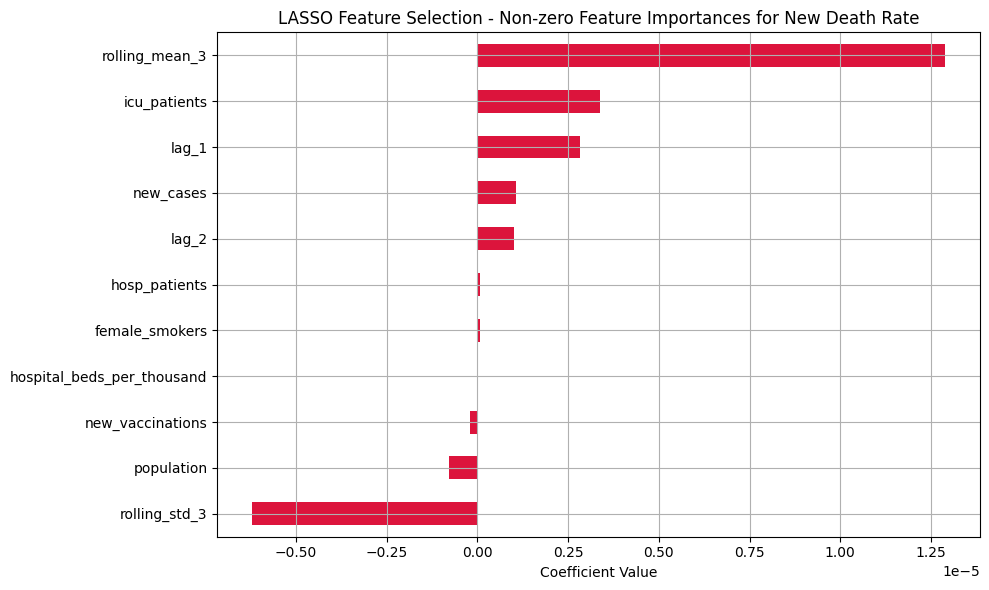

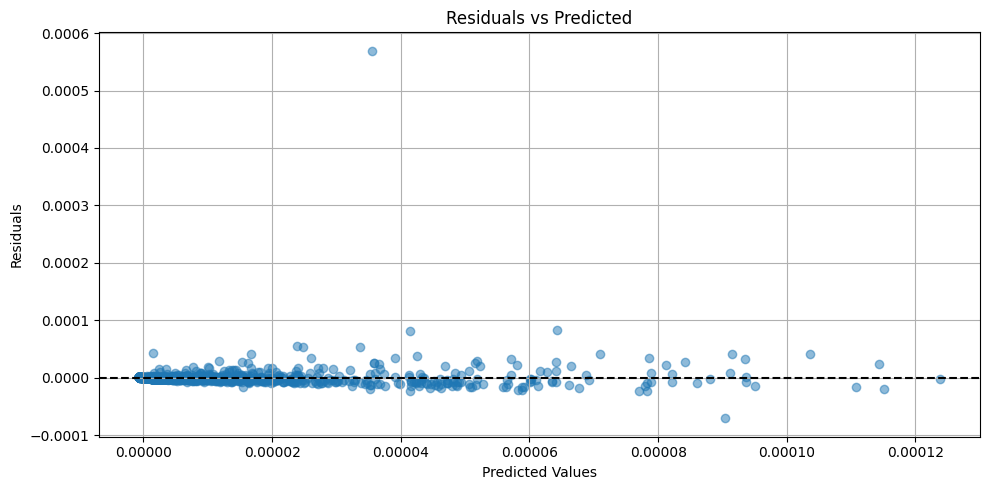

location
Canada          0.000003
Malaysia        0.000004
Australia       0.000004
South Africa    0.000005
Italy           0.000007
Czechia         0.000012
Chile           0.000038
dtype: float64


/tmp/ipython-input-3157421378.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(country_rmse.groupby('location').apply(lambda g: rmse(g['new_death_rate'], g['predicted'])).sort_values())


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Load and prepare data
df = pd.read_excel('/content/weekly_covid_data_combined.xlsx')
df = df[df['population'] > 0]
df['new_death_rate'] = df['new_deaths'] / df['population']
df = df[df['new_death_rate'].notna()]

# Sort for time-aware features
df = df.sort_values(by=['location', 'date'])

# Add week index (time index feature)
df['week_index'] = (df['date'] - df['date'].min()).dt.days // 7

# Encode country-level fixed effect using mean target encoding
country_avg_target = df.groupby('location')['new_death_rate'].mean()
df['country_mean_target'] = df['location'].map(country_avg_target)

# Add lag and rolling statistics
for lag in [1, 2, 3, 4]:
    df[f'lag_{lag}'] = df.groupby('location')['new_death_rate'].shift(lag)
df['rolling_mean_3'] = df.groupby('location')['new_death_rate'].shift(1).rolling(window=3).mean()
df['rolling_std_3'] = df.groupby('location')['new_death_rate'].shift(1).rolling(window=3).std()
df['ewma_3'] = df.groupby('location')['new_death_rate'].shift(1).ewm(span=3).mean()

# Drop NA after feature engineering
df = df.dropna()

# Define features and target
drop_cols = ['date', 'new_deaths', 'new_death_rate', 'location', 'continent']
X = df.drop(columns=drop_cols + ['new_death_rate'], errors='ignore')
y = df['new_death_rate']

# Ensure only numeric features
X_numeric = X.select_dtypes(include='number').fillna(0)

# LASSO with cross-validation
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])
lasso_pipeline.fit(X_numeric, y)

# Coefficients and Feature Importance
coefs = lasso_pipeline.named_steps['lasso'].coef_
features = X_numeric.columns
importance = pd.Series(coefs, index=features)
importance = importance[importance != 0].sort_values()

# Plot feature importances
plt.figure(figsize=(10, 6))
importance.plot(kind='barh', color='crimson')
plt.title('LASSO Feature Selection - Non-zero Feature Importances for New Death Rate')
plt.xlabel('Coefficient Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Residual analysis
y_pred = lasso_pipeline.predict(X_numeric)
residuals = y - y_pred

plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Country-level RMSE analysis
from sklearn.metrics import mean_squared_error

def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

country_rmse = df.copy()
country_rmse['predicted'] = y_pred
print(country_rmse.groupby('location').apply(lambda g: rmse(g['new_death_rate'], g['predicted'])).sort_values())


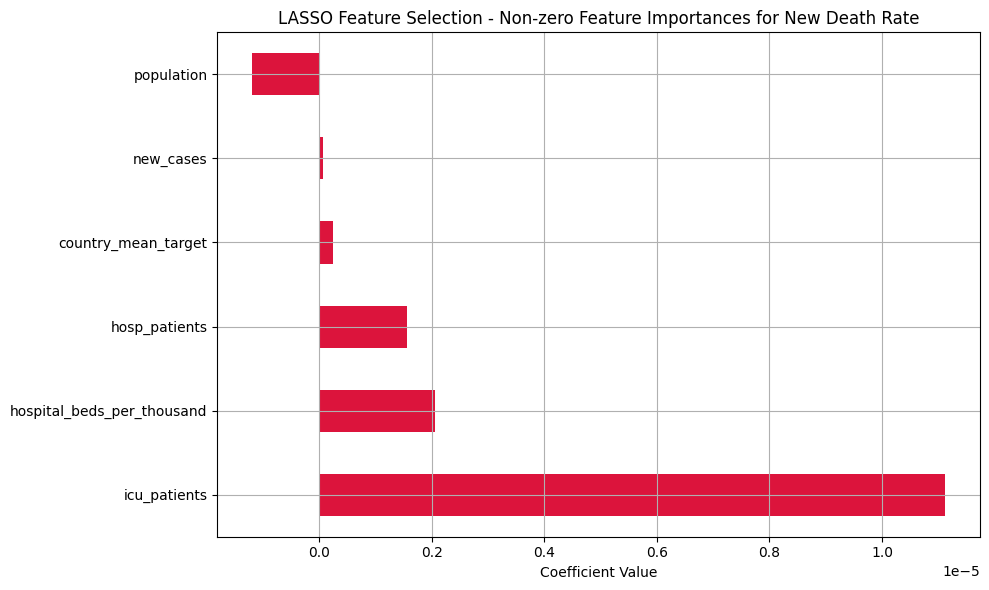

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 789
[LightGBM] [Info] Number of data points in the train set: 1351, number of used features: 6
[LightGBM] [Info] Start training from score 0.000012
--- Final Voting Ensemble Model Performance on Holdout Set ---
Root Mean Squared Error: 0.00
R² Score: 0.4617


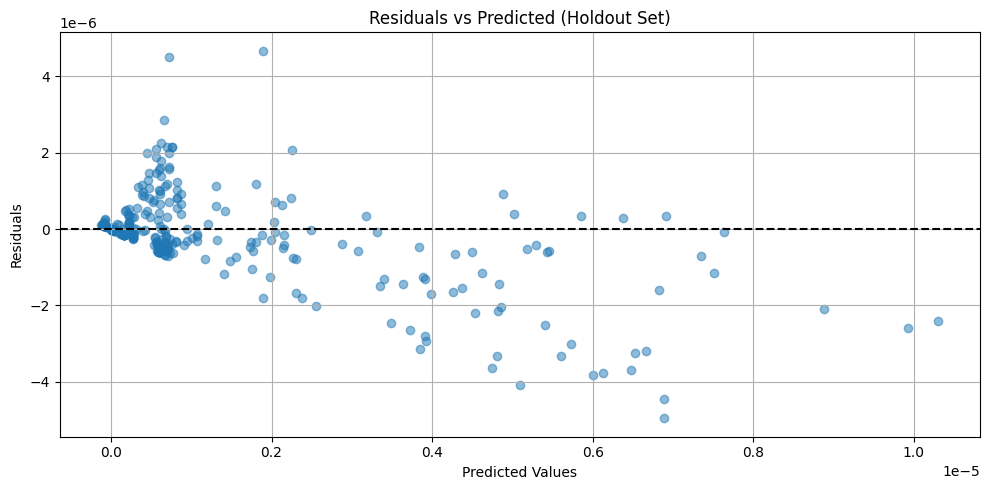


Per-country RMSE on Holdout:
location
South Africa    1.825227e-08
Malaysia        3.104279e-07
Czechia         5.077816e-07
Chile           1.010453e-06
Italy           1.145638e-06
Australia       1.404737e-06
Canada          2.196462e-06
dtype: float64


/tmp/ipython-input-3091732307.py:109: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(country_rmse.groupby('location').apply(lambda g: np.sqrt(mean_squared_error(g['new_death_rate'], g['predicted']))).sort_values())


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load and prepare data
df = pd.read_excel('/content/weekly_covid_data_combined.xlsx')
df = df[df['population'] > 0]
df['new_death_rate'] = df['new_deaths'] / df['population']
df = df[df['new_death_rate'].notna()]

# Sort for time-aware features
df = df.sort_values(by=['location', 'date'])

# Add week index (time index feature)
df['week_index'] = (df['date'] - df['date'].min()).dt.days // 7

# Encode country-level fixed effect using mean target encoding
country_avg_target = df.groupby('location')['new_death_rate'].mean()
df['country_mean_target'] = df['location'].map(country_avg_target)

# Drop NA before selection
df = df.dropna()

# Define features and target
drop_cols = ['date', 'new_deaths', 'new_death_rate', 'location', 'continent']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['new_death_rate']

# Ensure only numeric features
X_numeric = X.select_dtypes(include='number').fillna(0)

# Time-based train-test split using final 20% of time
split_index = int(df['week_index'].max() * 0.8)
train_mask = df['week_index'] <= split_index
test_mask = df['week_index'] > split_index

X_train = X_numeric[train_mask]
y_train = y[train_mask]
X_test = X_numeric[test_mask]
y_test = y[test_mask]

# LASSO feature selection
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])
lasso_pipeline.fit(X_train, y_train)

# Coefficients and Feature Importance
coefs = lasso_pipeline.named_steps['lasso'].coef_
features = X_train.columns
importance = pd.Series(coefs, index=features)
selected_features = importance[importance != 0].sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
selected_features.plot(kind='barh', color='crimson')
plt.title('LASSO Feature Selection - Non-zero Feature Importances for New Death Rate')
plt.xlabel('Coefficient Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Use selected features in main model
X_train_sel = X_train[selected_features.index]
X_test_sel = X_test[selected_features.index]

# Voting Regressor using selected features
ensemble = VotingRegressor([
    ('lgbm', LGBMRegressor(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
])
ensemble.fit(X_train_sel, y_train)

# Predictions
y_pred = ensemble.predict(X_test_sel)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("--- Final Voting Ensemble Model Performance on Holdout Set ---")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals vs Predicted (Holdout Set)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Country-level RMSE on holdout
country_rmse = df[test_mask].copy()
country_rmse['predicted'] = y_pred
print("\nPer-country RMSE on Holdout:")
print(country_rmse.groupby('location').apply(lambda g: np.sqrt(mean_squared_error(g['new_death_rate'], g['predicted']))).sort_values())


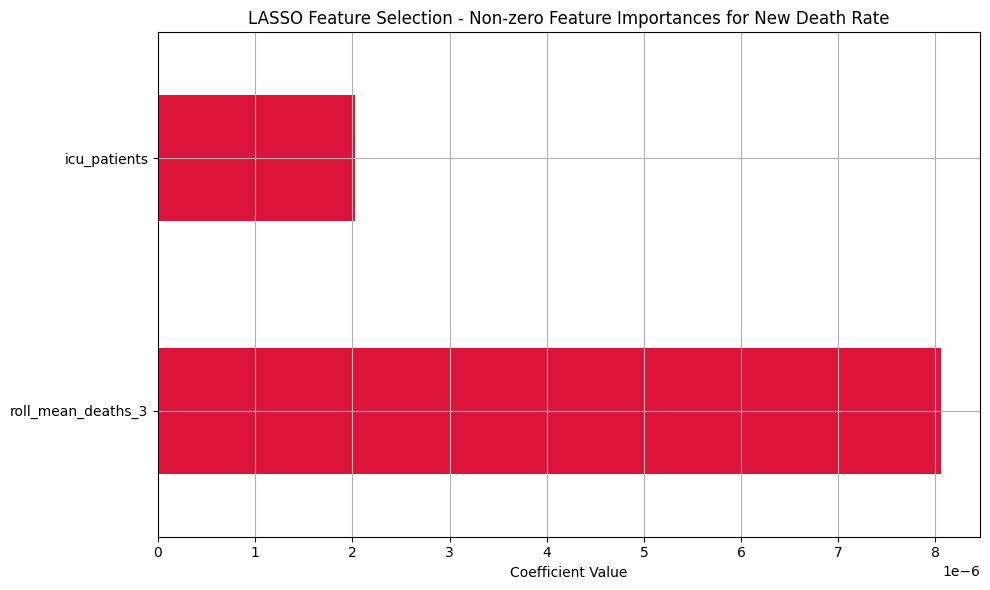

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1316, number of used features: 2
[LightGBM] [Info] Start training from score 0.000012
--- Final Voting Ensemble Model Performance on Holdout Set ---
Root Mean Squared Error: 0.00
R² Score: 0.7614


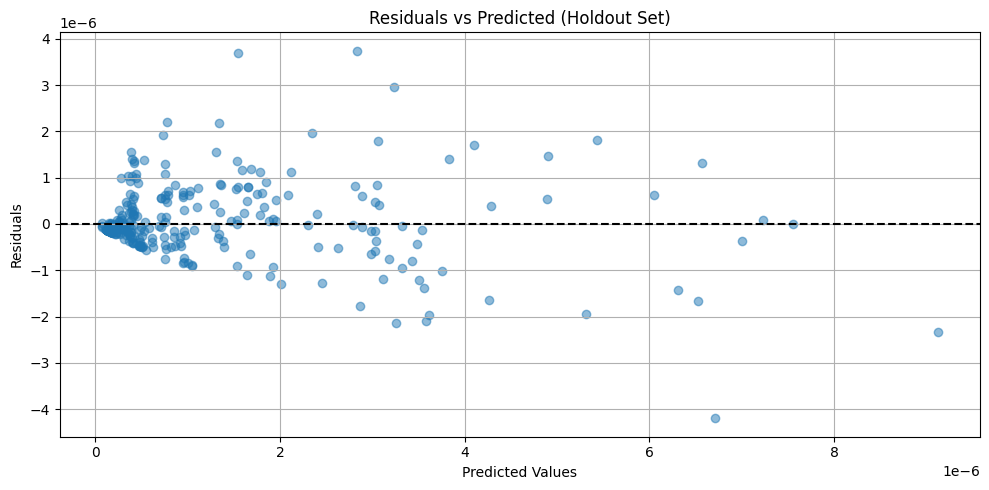


Per-country RMSE on Holdout:
location
South Africa    1.261693e-07
Malaysia        2.493949e-07
Chile           7.641093e-07
Czechia         7.711740e-07
Canada          7.932973e-07
Australia       1.059990e-06
Italy           1.077992e-06
dtype: float64


/tmp/ipython-input-3176197466.py:119: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  print(country_rmse.groupby('location').apply(lambda g: np.sqrt(mean_squared_error(g['new_death_rate'], g['predicted']))).sort_values())


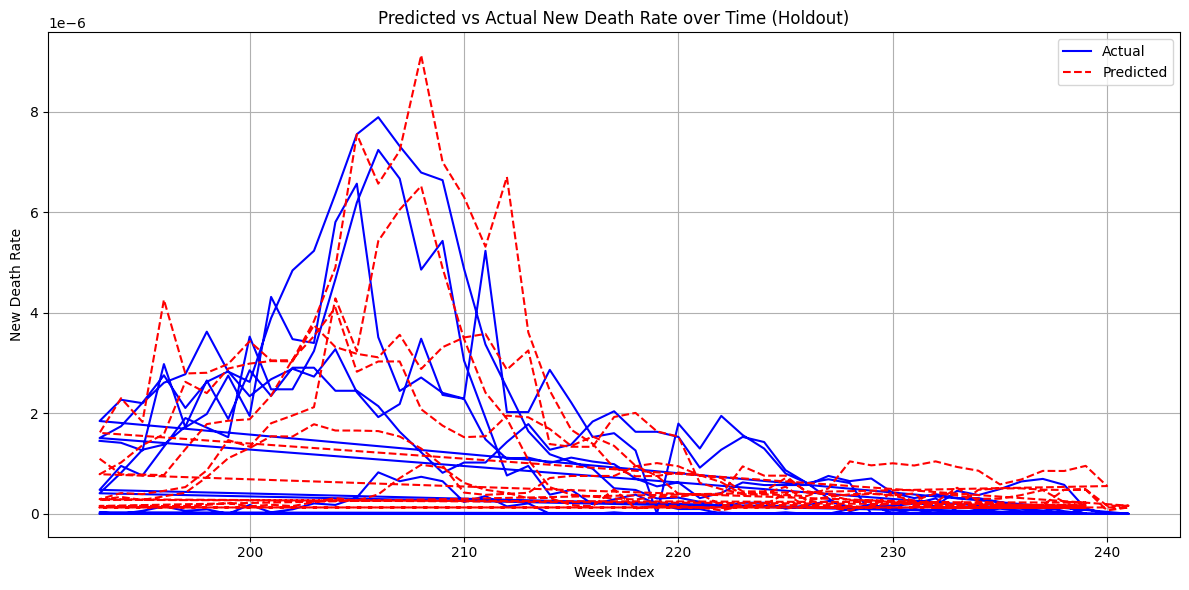

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load and prepare data
df = pd.read_excel('/content/weekly_covid_data_combined.xlsx')
df = df[df['population'] > 0]
df['new_death_rate'] = df['new_deaths'] / df['population']
df['new_case_rate'] = df['new_cases'] / df['population']
df = df[df['new_death_rate'].notna()]

# Sort for time-aware features
df = df.sort_values(by=['location', 'date'])

# Add week index (time index feature)
df['week_index'] = (df['date'] - df['date'].min()).dt.days // 7

# Encode country-level fixed effect using mean target encoding
country_avg_target = df.groupby('location')['new_death_rate'].mean()
df['country_mean_target'] = df['location'].map(country_avg_target)

# Add lag and rolling features
for lag in [1, 2, 3]:
    df[f'lag_deaths_{lag}'] = df.groupby('location')['new_death_rate'].shift(lag)
    df[f'lag_cases_{lag}'] = df.groupby('location')['new_case_rate'].shift(lag)

for window in [3, 5]:
    df[f'roll_mean_deaths_{window}'] = df.groupby('location')['new_death_rate'].shift(1).rolling(window).mean().reset_index(level=0, drop=True)
    df[f'roll_mean_cases_{window}'] = df.groupby('location')['new_case_rate'].shift(1).rolling(window).mean().reset_index(level=0, drop=True)

# Drop NA before selection
df = df.dropna()

# Define features and target
drop_cols = ['date', 'new_deaths', 'new_death_rate', 'location', 'continent']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['new_death_rate']

# Ensure only numeric features
X_numeric = X.select_dtypes(include='number').fillna(0)

# Time-based train-test split using final 20% of time
split_index = int(df['week_index'].max() * 0.8)
train_mask = df['week_index'] <= split_index
test_mask = df['week_index'] > split_index

X_train = X_numeric[train_mask]
y_train = y[train_mask]
X_test = X_numeric[test_mask]
y_test = y[test_mask]

# LASSO feature selection
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', LassoCV(cv=5, random_state=42))
])
lasso_pipeline.fit(X_train, y_train)

# Coefficients and Feature Importance
coefs = lasso_pipeline.named_steps['lasso'].coef_
features = X_train.columns
importance = pd.Series(coefs, index=features)
selected_features = importance[importance != 0].sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
selected_features.plot(kind='barh', color='crimson')
plt.title('LASSO Feature Selection - Non-zero Feature Importances for New Death Rate')
plt.xlabel('Coefficient Value')
plt.grid(True)
plt.tight_layout()
plt.show()

# Use selected features in main model
X_train_sel = X_train[selected_features.index]
X_test_sel = X_test[selected_features.index]

# Voting Regressor using selected features
ensemble = VotingRegressor([
    ('lgbm', LGBMRegressor(random_state=42)),
    ('rf', RandomForestRegressor(random_state=42)),
    ('gbr', GradientBoostingRegressor(random_state=42))
])
ensemble.fit(X_train_sel, y_train)

# Predictions
y_pred = ensemble.predict(X_test_sel)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("--- Final Voting Ensemble Model Performance on Holdout Set ---")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals vs Predicted (Holdout Set)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Country-level RMSE on holdout
country_rmse = df[test_mask].copy()
country_rmse['predicted'] = y_pred
print("\nPer-country RMSE on Holdout:")
print(country_rmse.groupby('location').apply(lambda g: np.sqrt(mean_squared_error(g['new_death_rate'], g['predicted']))).sort_values())

# Additional: Predicted vs Actual New Death Rate over Time
time_df = df[test_mask].copy()
time_df['predicted'] = y_pred
plt.figure(figsize=(12, 6))
plt.plot(time_df['week_index'], time_df['new_death_rate'], label='Actual', color='blue')
plt.plot(time_df['week_index'], time_df['predicted'], label='Predicted', color='red', linestyle='--')
plt.title('Predicted vs Actual New Death Rate over Time (Holdout)')
plt.xlabel('Week Index')
plt.ylabel('New Death Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OrdinalEncoder
from skopt import BayesSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and prepare the data
df = pd.read_excel('weekly_covid_data_combined.xlsx')

# 2. Drop rows with missing or invalid values
df = df[(df['population'] > 0) & (df['new_cases'].notna())]

# 3. Target: cases per capita
df['new_cases_per_capita'] = df['new_cases'] / df['population']

# 4. Sort by location and date
df = df.sort_values(by=['location', 'date'])

# 5. Feature Engineering: lag, rolling, ewma
for lag in range(1, 8):
    df[f'lag_{lag}'] = df.groupby('location')['new_cases_per_capita'].shift(lag)

df['rolling_mean_3'] = df.groupby('location')['new_cases_per_capita'].transform(lambda x: x.shift(1).rolling(3).mean())
df['rolling_std_7'] = df.groupby('location')['new_cases_per_capita'].transform(lambda x: x.shift(1).rolling(7).std())
df['ewma_3'] = df.groupby('location')['new_cases_per_capita'].transform(lambda x: x.shift(1).ewm(span=3).mean())

# 6. Policy Features
policy_cols = ['stringency_index']
for col in policy_cols:
    df[f'{col}_lag1'] = df.groupby('location')[col].shift(1)
    df[f'{col}_rolling3'] = df.groupby('location')[col].transform(lambda x: x.shift(1).rolling(3).mean())

# 7. Date Features
df['weekofyear'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['is_holiday_week'] = df['weekofyear'].isin([1, 52]).astype(int)

# 8. Encode location
df['location_encoded'] = OrdinalEncoder().fit_transform(df[['location']])

# 9. Drop rows with any remaining NA
df = df.dropna()

# 10. Define features and target
drop_cols = ['date', 'new_cases', 'new_cases_per_capita', 'location', 'continent']
X = df.drop(columns=drop_cols, errors='ignore').fillna(0)
y = df['new_cases_per_capita']
populations = df['population']
true_new_cases = df['new_cases']

# 11. Train/Test Split (time-aware)
X_train, X_test, y_train, y_test, pop_train, pop_test, true_cases_train, true_cases_test = train_test_split(
    X, y, populations, true_new_cases, test_size=0.2, shuffle=False
)

# 12. Define base and final models
lgb_model = lgb.LGBMRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
ridge_model = Ridge()

stacked_model = StackingRegressor(
    estimators=[
        ('lgb', lgb_model),
        ('rf', rf_model),
        ('ridge', ridge_model)
    ],
    final_estimator=lgb.LGBMRegressor(),
    passthrough=True,
    n_jobs=-1
)

# 13. Bayesian Optimization
param_space = {
    'final_estimator__n_estimators': (100, 500),
    'final_estimator__max_depth': (3, 10),
    'final_estimator__learning_rate': (0.005, 0.1, 'log-uniform')
}

tscv = TimeSeriesSplit(n_splits=5)

opt_search = BayesSearchCV(
    stacked_model,
    param_space,
    cv=tscv,
    n_iter=25,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

opt_search.fit(X_train, y_train)

# 14. Predict & Evaluate
best_model = opt_search.best_estimator_
y_pred_normalized = best_model.predict(X_test)
y_pred_actual = y_pred_normalized * pop_test.values

mse = mean_squared_error(true_cases_test, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(true_cases_test, y_pred_actual)

print("\n--- Final Model Performance on Holdout Set ---")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# 15. Visualizations
test_index = X_test.index
test_meta = df.loc[test_index, ['date', 'location']].copy()
test_meta['actual_new_cases'] = true_cases_test.values
test_meta['predicted_new_cases'] = y_pred_actual
test_meta['abs_error'] = np.abs(test_meta['actual_new_cases'] - test_meta['predicted_new_cases'])

# Line Plot
plt.figure(figsize=(12, 6))
plt.plot(test_meta['date'], test_meta['actual_new_cases'], label='Actual', linewidth=2)
plt.plot(test_meta['date'], test_meta['predicted_new_cases'], label='Predicted', linestyle='--', linewidth=2)
plt.title('COVID-19: Actual vs Predicted New Cases (Holdout Set)')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Scatter Plot
plt.figure(figsize=(6, 6))
plt.scatter(test_meta['actual_new_cases'], test_meta['predicted_new_cases'], alpha=0.5)
plt.plot([0, max(test_meta['actual_new_cases'])], [0, max(test_meta['actual_new_cases'])], 'r--')
plt.xlabel('Actual New Cases')
plt.ylabel('Predicted New Cases')
plt.title('Predicted vs Actual New Cases')
plt.grid(True)
plt.tight_layout()
plt.show()

# Country-Level Error Analysis
country_errors = test_meta.groupby('location')['abs_error'].mean().sort_values(ascending=False)
print("\n--- Top 10 Countries with Highest Average Absolute Error ---")
print(country_errors.head(10))

# Rolling RMSE Over Time
test_meta['rolling_rmse'] = test_meta['abs_error'].rolling(window=4).mean()
plt.figure(figsize=(12, 4))
plt.plot(test_meta['date'], test_meta['rolling_rmse'], label='Rolling RMSE (4-week)')
plt.title('Rolling RMSE Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling RMSE')
plt.grid(True)
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'skopt'

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.8 MB/s eta 0:00:00


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


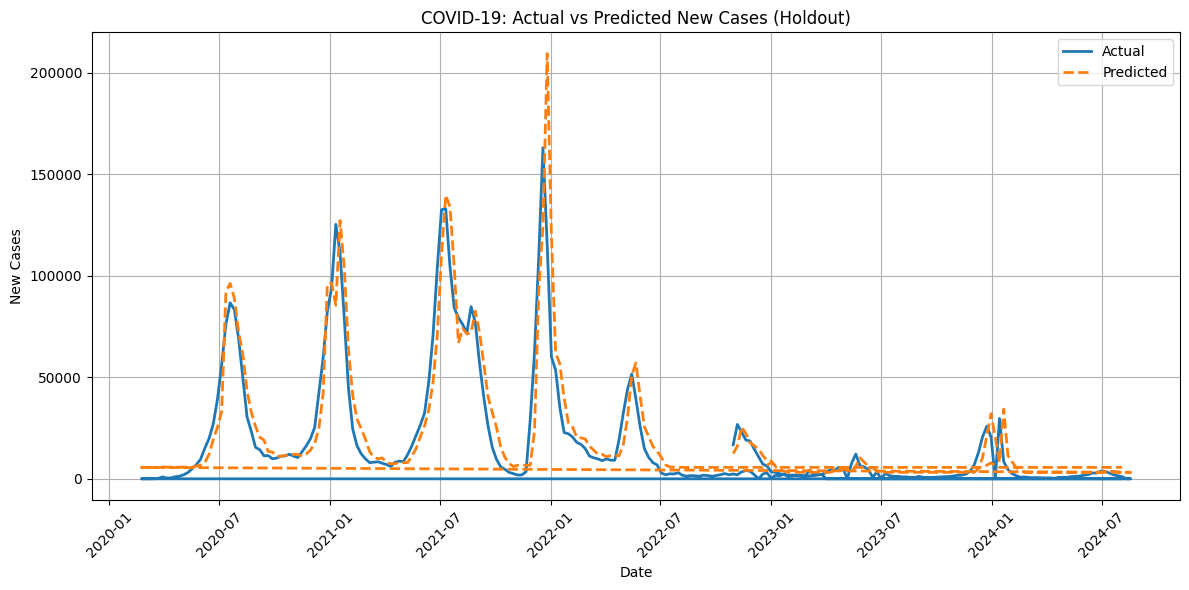

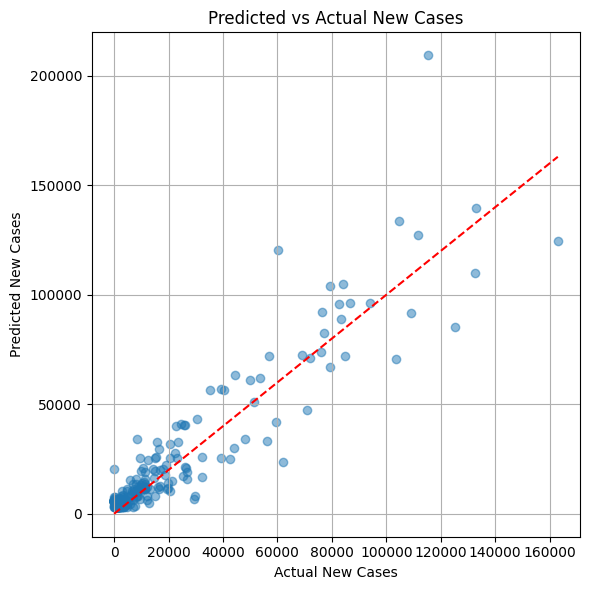


--- Top 10 Countries by Absolute Error ---
location
South Africa    7757.358785
Malaysia        3268.459416
Name: abs_error, dtype: float64


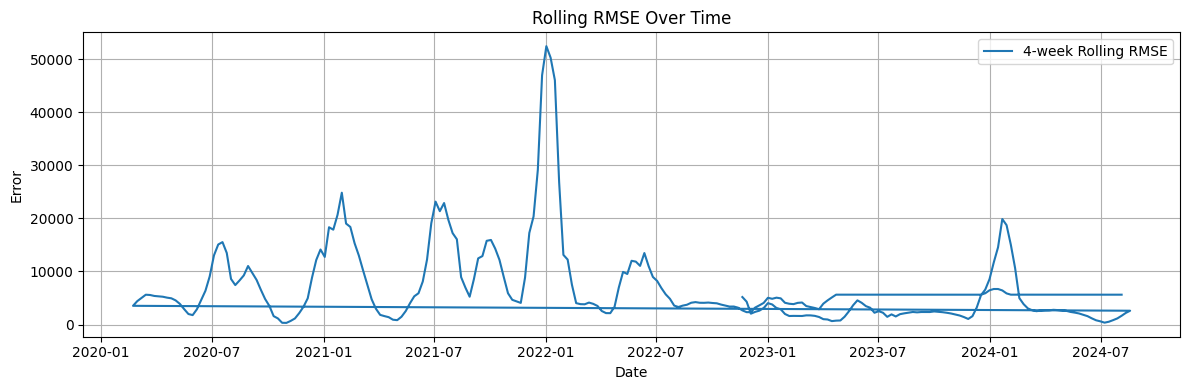

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OrdinalEncoder
from skopt import BayesSearchCV
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and prepare the data
df = pd.read_excel('weekly_covid_data_combined.xlsx')
df = df.copy()

# 2. Drop rows with missing or invalid values
df = df[(df['population'] > 0) & (df['new_cases'].notna())]

# 3. Create per capita target
df['new_cases_per_capita'] = df['new_cases'] / df['population']

# 4. Ensure datetime format
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by=['location', 'date'])

# 5. Lag & rolling features on target
for lag in range(1, 8):
    df[f'lag_{lag}'] = df.groupby('location')['new_cases_per_capita'].shift(lag)

df['rolling_mean_3'] = df.groupby('location')['new_cases_per_capita'].transform(lambda x: x.shift(1).rolling(3).mean())
df['rolling_std_7'] = df.groupby('location')['new_cases_per_capita'].transform(lambda x: x.shift(1).rolling(7).std())
df['ewma_3'] = df.groupby('location')['new_cases_per_capita'].transform(lambda x: x.shift(1).ewm(span=3).mean())

# 6. Policy feature (if available)
if 'stringency_index' in df.columns:
    df['stringency_index_lag1'] = df.groupby('location')['stringency_index'].shift(1)
    df['stringency_index_rolling3'] = df.groupby('location')['stringency_index'].transform(lambda x: x.shift(1).rolling(3).mean())

# Weekly time features
df['year'] = df['date'].dt.year
df['weekofyear'] = df['date'].dt.isocalendar().week
df['weeks_since_start'] = (df['date'] - df['date'].min()).dt.days // 7
df['is_year_end'] = df['weekofyear'].isin([51, 52, 1]).astype(int)


# 8. Encode country
df['location_encoded'] = OrdinalEncoder().fit_transform(df[['location']])

# 9. Drop remaining NA
df = df.dropna()

# 10. Features and target
drop_cols = ['date', 'new_cases', 'new_cases_per_capita', 'location', 'continent']
X = df.drop(columns=drop_cols, errors='ignore').fillna(0)
y = df['new_cases_per_capita']
populations = df['population']
true_new_cases = df['new_cases']

# 11. Split
X_train, X_test, y_train, y_test, pop_train, pop_test, true_cases_train, true_cases_test = train_test_split(
    X, y, populations, true_new_cases, test_size=0.2, shuffle=False
)

# 12. Models
lgb_model = lgb.LGBMRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
ridge_model = Ridge()

stacked_model = StackingRegressor(
    estimators=[
        ('lgb', lgb_model),
        ('rf', rf_model),
        ('ridge', ridge_model)
    ],
    final_estimator=lgb.LGBMRegressor(),
    passthrough=True,
    n_jobs=-1
)

# 13. Bayesian search
param_space = {
    'final_estimator__n_estimators': (100, 500),
    'final_estimator__max_depth': (3, 10),
    'final_estimator__learning_rate': (0.005, 0.1, 'log-uniform')
}

tscv = TimeSeriesSplit(n_splits=5)

opt_search = BayesSearchCV(
    stacked_model,
    param_space,
    cv=tscv,
    n_iter=25,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

opt_search.fit(X_train, y_train)

# 14. Predict and evaluate
best_model = opt_search.best_estimator_
y_pred_normalized = best_model.predict(X_test)
y_pred_actual = y_pred_normalized * pop_test.values

mse = mean_squared_error(true_cases_test, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(true_cases_test, y_pred_actual)

print("\n--- Final Model Performance on Holdout Set ---")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# 15. Test meta & plots
test_index = X_test.index
test_meta = df.loc[test_index, ['date', 'location']].copy()
test_meta['actual_new_cases'] = true_cases_test.values
test_meta['predicted_new_cases'] = y_pred_actual
test_meta['abs_error'] = np.abs(test_meta['actual_new_cases'] - test_meta['predicted_new_cases'])

# Line plot
plt.figure(figsize=(12, 6))
plt.plot(test_meta['date'], test_meta['actual_new_cases'], label='Actual', linewidth=2)
plt.plot(test_meta['date'], test_meta['predicted_new_cases'], label='Predicted', linestyle='--', linewidth=2)
plt.title('COVID-19: Actual vs Predicted New Cases (Holdout)')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(6, 6))
plt.scatter(test_meta['actual_new_cases'], test_meta['predicted_new_cases'], alpha=0.5)
plt.plot([0, max(test_meta['actual_new_cases'])], [0, max(test_meta['actual_new_cases'])], 'r--')
plt.xlabel('Actual New Cases')
plt.ylabel('Predicted New Cases')
plt.title('Predicted vs Actual New Cases')
plt.grid(True)
plt.tight_layout()
plt.show()

# Top error countries
country_errors = test_meta.groupby('location')['abs_error'].mean().sort_values(ascending=False)
print("\n--- Top 10 Countries by Absolute Error ---")
print(country_errors.head(10))

# Rolling RMSE over time
test_meta['rolling_rmse'] = test_meta['abs_error'].rolling(window=4).mean()
plt.figure(figsize=(12, 4))
plt.plot(test_meta['date'], test_meta['rolling_rmse'], label='4-week Rolling RMSE')
plt.title('Rolling RMSE Over Time')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


#Statistical Feature Selection
These are very promising results provided after carrying out Statistical Feature Selection

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2532
[LightGBM] [Info] Number of data points in the train set: 1331, number of used features: 16
[LightGBM] [Info] Start training from score 43944.266717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


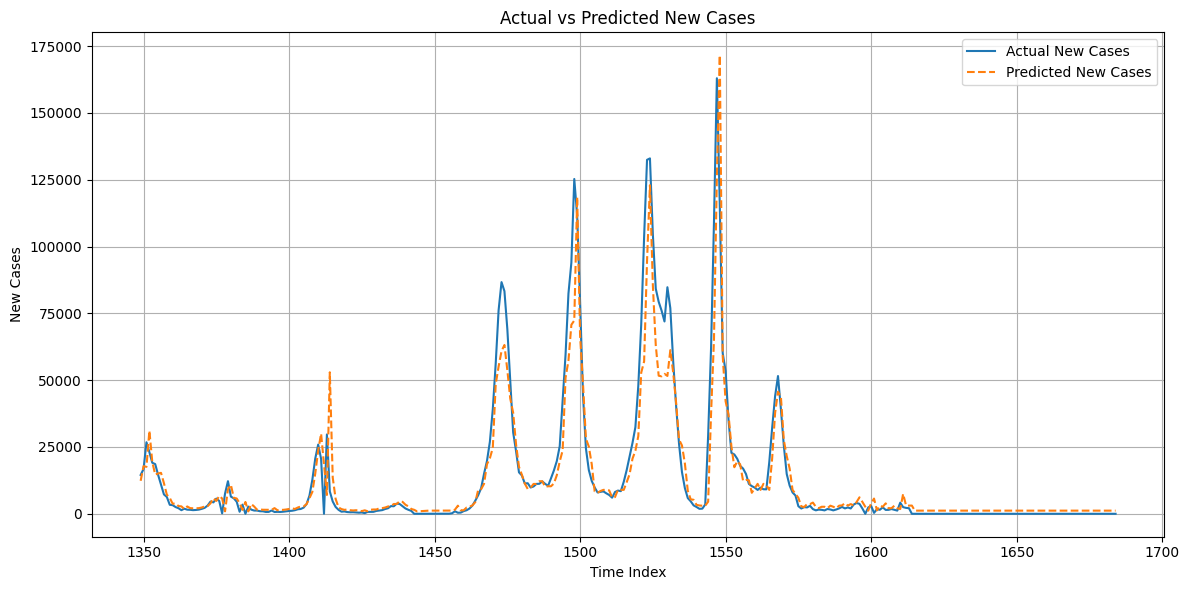

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1. Load original data
df = pd.read_excel('weekly_covid_data_combined.xlsx')

# 2. Filter for valid entries
df = df[(df['population'] > 0) & (df['new_cases'].notna())].copy()

# 3. Define selected features
selected_features = [
    'new_tests', 'people_fully_vaccinated', 'new_vaccinations', 'total_boosters',
    'aged_70_older', 'median_age', 'population_density',
    'aged_65_older', 'population', 'life_expectancy'
]

# 4. Sort by country and date
df = df.sort_values(by=['location', 'date'])

# 5. Add lag and rolling features from the target variable (per location)
for lag in [1, 2, 3]:
    df[f'lag_{lag}'] = df.groupby('location')['new_cases'].shift(lag)
df['rolling_mean_3'] = df.groupby('location')['new_cases'].shift(1).rolling(3).mean()

# 6. Drop rows with missing values due to shifting
df = df.dropna(subset=selected_features + ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'new_cases'])

# 7. Create new working dataframe
final_features = selected_features + ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3']
X = df[final_features].fillna(0)
y = df['new_cases']

# 8. Train-test split (no shuffle due to time series nature)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# 9. Define base and final estimators
rf = RandomForestRegressor(n_estimators=100, random_state=42)
ridge = Ridge(alpha=1.0)
lgbm_final = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=7, random_state=42)

# 10. Define stacking model
stack_model = StackingRegressor(
    estimators=[('rf', rf), ('ridge', ridge)],
    final_estimator=lgbm_final,
    passthrough=True,
    n_jobs=-1
)

# 11. Train model
stack_model.fit(X_train, y_train)

# 12. Predict and evaluate
y_pred = stack_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Final Stacking Model Performance ---")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# 13. Plot predicted vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual New Cases')
plt.plot(y_test.index, y_pred, label='Predicted New Cases', linestyle='--')
plt.xlabel("Time Index")
plt.ylabel("New Cases")
plt.title("Actual vs Predicted New Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


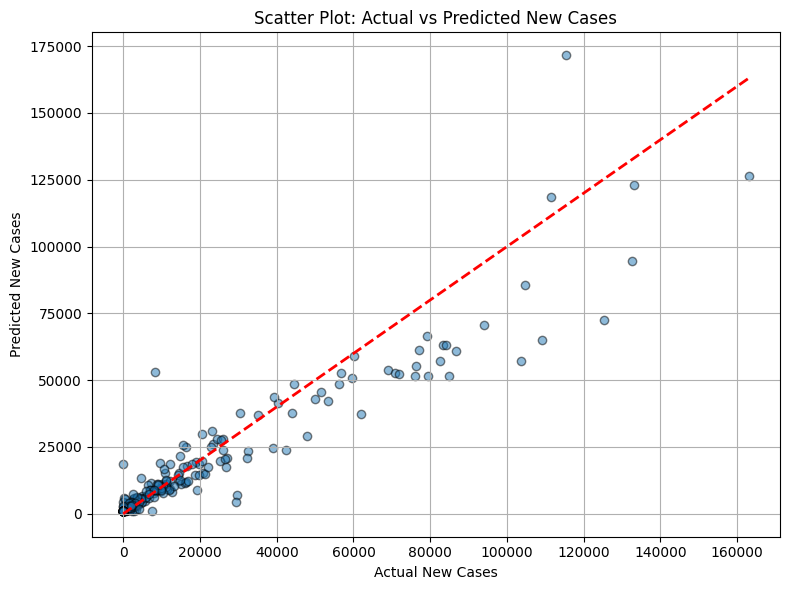

In [ ]:
# 14. Scatter plot: Predicted vs Actual new_cases
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual New Cases")
plt.ylabel("Predicted New Cases")
plt.title("Scatter Plot: Actual vs Predicted New Cases")
plt.grid(True)
plt.tight_layout()
plt.show()


#Neural Network Feature Selection
The following code runs the model with feature selection carried out by the nueral network only

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3583
[LightGBM] [Info] Number of data points in the train set: 1331, number of used features: 28
[LightGBM] [Info] Start training from score 43944.266717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


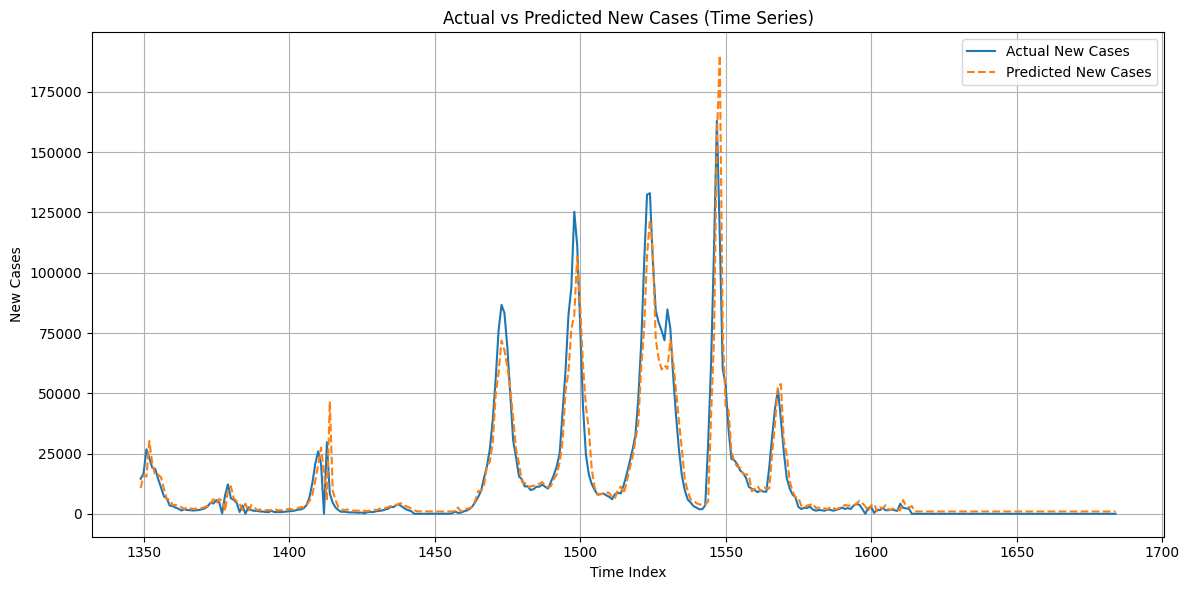

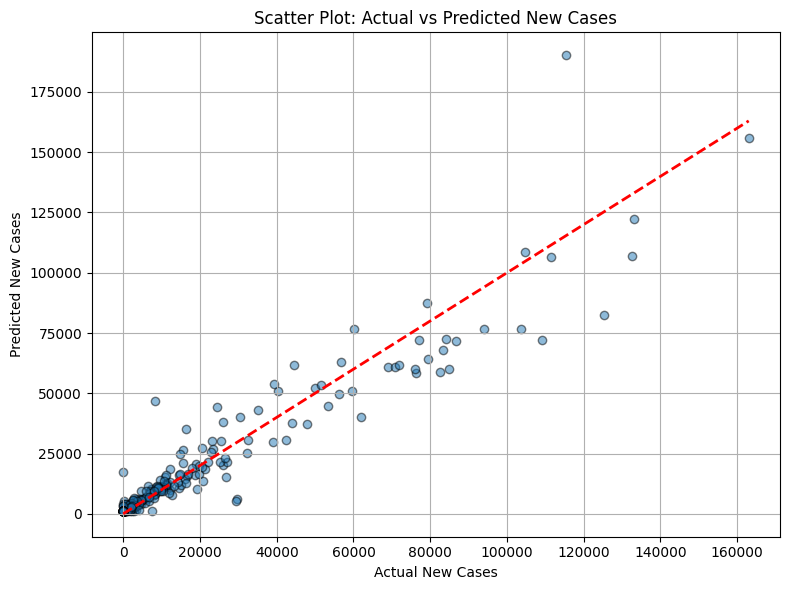

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1. Load original data
df = pd.read_excel('weekly_covid_data_combined.xlsx')

# 2. Filter for valid entries
df = df[(df['population'] > 0) & (df['new_cases'].notna())].copy()

# 3. Define updated feature list
selected_features = [
    'people_fully_vaccinated', 'total_boosters', 'new_tests', 'hosp_patients',
    'new_deaths', 'new_vaccinations', 'hospital_beds_per_thousand', 'icu_patients',
    'extreme_poverty', 'human_development_index', 'diabetes_prevalence',
    'life_expectancy', 'female_smokers', 'gdp_per_capita', 'cardiovasc_death_rate',
    'male_smokers', 'aged_70_older', 'aged_65_older', 'population_density',
    'median_age', 'stringency_index', 'population'
]

# 4. Sort by country and date
df = df.sort_values(by=['location', 'date'])

# 5. Add lag and rolling mean of target
for lag in [1, 2, 3]:
    df[f'lag_{lag}'] = df.groupby('location')['new_cases'].shift(lag)
df['rolling_mean_3'] = df.groupby('location')['new_cases'].shift(1).rolling(3).mean()

# 6. Drop rows with missing values due to lag/rolling + selected features
df = df.dropna(subset=selected_features + ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'new_cases'])

# 7. Prepare model input
final_features = selected_features + ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3']
X = df[final_features].fillna(0)
y = df['new_cases']

# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# 9. Define models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
ridge = Ridge(alpha=1.0)
lgbm_final = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=7, random_state=42)

# 10. Define stacking ensemble
stack_model = StackingRegressor(
    estimators=[('rf', rf), ('ridge', ridge)],
    final_estimator=lgbm_final,
    passthrough=True,
    n_jobs=-1
)

# 11. Fit model
stack_model.fit(X_train, y_train)

# 12. Evaluate
y_pred = stack_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n--- Final Stacking Model Performance ---")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# 13. Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual New Cases')
plt.plot(y_test.index, y_pred, label='Predicted New Cases', linestyle='--')
plt.xlabel("Time Index")
plt.ylabel("New Cases")
plt.title("Actual vs Predicted New Cases (Time Series)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 14. Scatter Plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual New Cases")
plt.ylabel("Predicted New Cases")
plt.title("Scatter Plot: Actual vs Predicted New Cases")
plt.grid(True)
plt.tight_layout()
plt.show()


#LASSO Feature Selection

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2759
[LightGBM] [Info] Number of data points in the train set: 1331, number of used features: 13
[LightGBM] [Info] Start training from score 43944.266717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


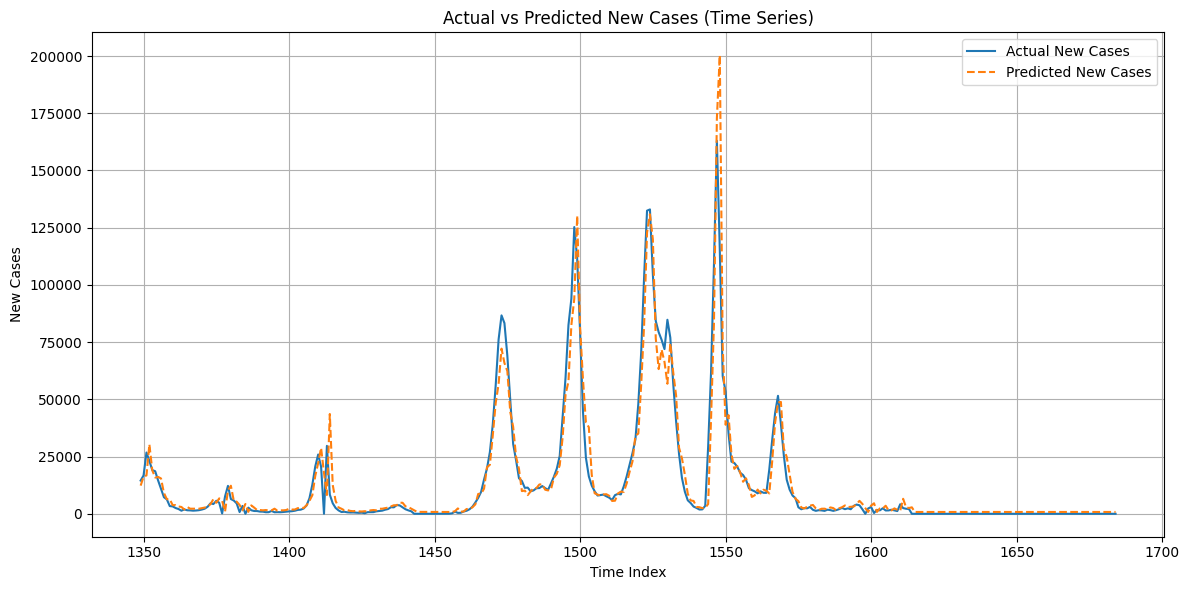

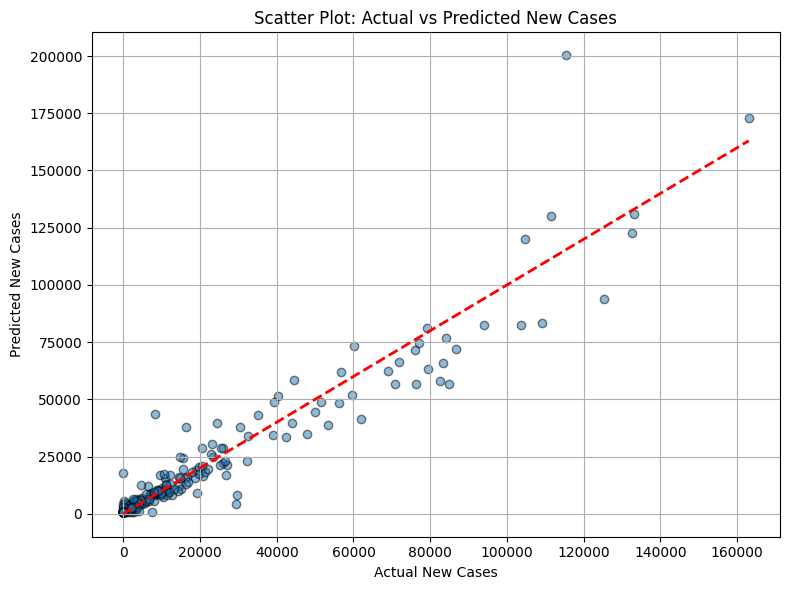

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1. Load data
df = pd.read_excel('weekly_covid_data_combined.xlsx')

# 2. Filter valid rows
df = df[(df['population'] > 0) & (df['new_cases'].notna())].copy()

# 3. Define selected features
selected_features = [
    'new_tests', 'total_boosters', 'new_deaths', 'hospital_beds_per_thousand',
    'hosp_patients', 'people_fully_vaccinated', 'population'
]

# 4. Sort by location and date
df = df.sort_values(by=['location', 'date'])

# 5. Create lag features of target
for lag in [1, 2, 3]:
    df[f'lag_{lag}'] = df.groupby('location')['new_cases'].shift(lag)
df['rolling_mean_3'] = df.groupby('location')['new_cases'].shift(1).rolling(3).mean()

# 6. Drop NA rows from lag/rolling + features
df = df.dropna(subset=selected_features + ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'new_cases'])

# 7. Final feature list
final_features = selected_features + ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3']
X = df[final_features].fillna(0)
y = df['new_cases']

# 8. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# 9. Define base models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
ridge = Ridge(alpha=1.0)
lgbm_final = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, max_depth=7, random_state=42)

# 10. Stacking Regressor
stack_model = StackingRegressor(
    estimators=[('rf', rf), ('ridge', ridge)],
    final_estimator=lgbm_final,
    passthrough=True,
    n_jobs=-1
)

# 11. Fit the model
stack_model.fit(X_train, y_train)

# 12. Predict
y_pred = stack_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 13. Report
print("\n--- Final Stacking Model Performance ---")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# 14. Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual New Cases')
plt.plot(y_test.index, y_pred, label='Predicted New Cases', linestyle='--')
plt.xlabel("Time Index")
plt.ylabel("New Cases")
plt.title("Actual vs Predicted New Cases (Time Series)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 15. Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel("Actual New Cases")
plt.ylabel("Predicted New Cases")
plt.title("Scatter Plot: Actual vs Predicted New Cases")
plt.grid(True)
plt.tight_layout()
plt.show()


##Predicting new_deaths and comparing our results



--- Evaluation for Random Forest Predicted New Deaths (absolute values) ---
Mean Squared Error: 19022.206811548906
Root Mean Squared Error: 137.92101656944422
R² Score: 0.9098011919109353


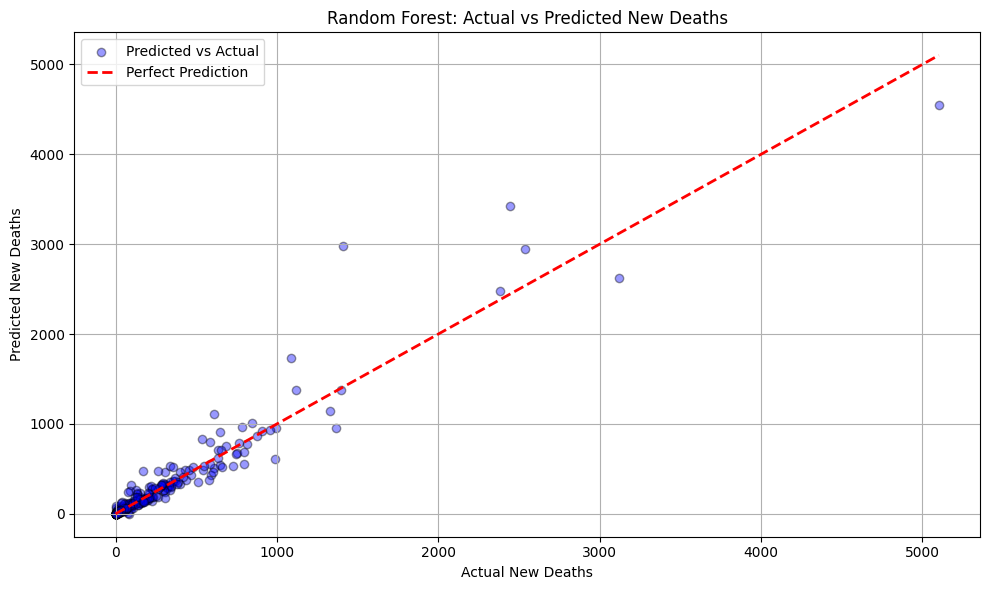

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load dataset
df = pd.read_excel('/content/weekly_covid_data_combined.xlsx')

# Create target variable: new death rate (deaths per person)
df = df[df['population'] > 0]
df['new_death_rate'] = df['new_deaths'] / df['population']

# Drop rows with missing target
df = df[df['new_death_rate'].notna()]

# Drop unused columns
drop_cols = ['date', 'new_deaths', 'new_death_rate', 'location', 'continent']
categorical_cols = [col for col in ['location', 'continent'] if col in df.columns]

# Prepare features
X = df.drop(columns=drop_cols, errors='ignore')
y = df['new_death_rate']
numerical_cols = X.select_dtypes(include='number').columns.tolist()
all_features = numerical_cols + categorical_cols
X = df[all_features].fillna(0)

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# Random Forest pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Reconstruct true & predicted new deaths
X_test_df = X_test.copy()
X_test_df['population'] = df.loc[X_test.index, 'population'].values
true_new_deaths = df.loc[X_test.index, 'new_deaths'].values
predicted_new_deaths = y_pred * X_test_df['population'].values

# Evaluate
mse = mean_squared_error(true_new_deaths, predicted_new_deaths)
rmse = np.sqrt(mse)
r2 = r2_score(true_new_deaths, predicted_new_deaths)

print("\n--- Evaluation for Random Forest Predicted New Deaths (absolute values) ---")
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.scatter(true_new_deaths, predicted_new_deaths, alpha=0.4, color='blue', edgecolor='k', label='Predicted vs Actual')
plt.plot([true_new_deaths.min(), true_new_deaths.max()],
         [true_new_deaths.min(), true_new_deaths.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual New Deaths')
plt.ylabel('Predicted New Deaths')
plt.title('Random Forest: Actual vs Predicted New Deaths')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Predicting New Deaths with Features from Statistical Feature Selection



--- Evaluation for Random Forest Predicted New Deaths (absolute values) ---
Mean Squared Error: 38838.2545408089
Root Mean Squared Error: 197.07423611626382
R² Score: 0.815838177844129


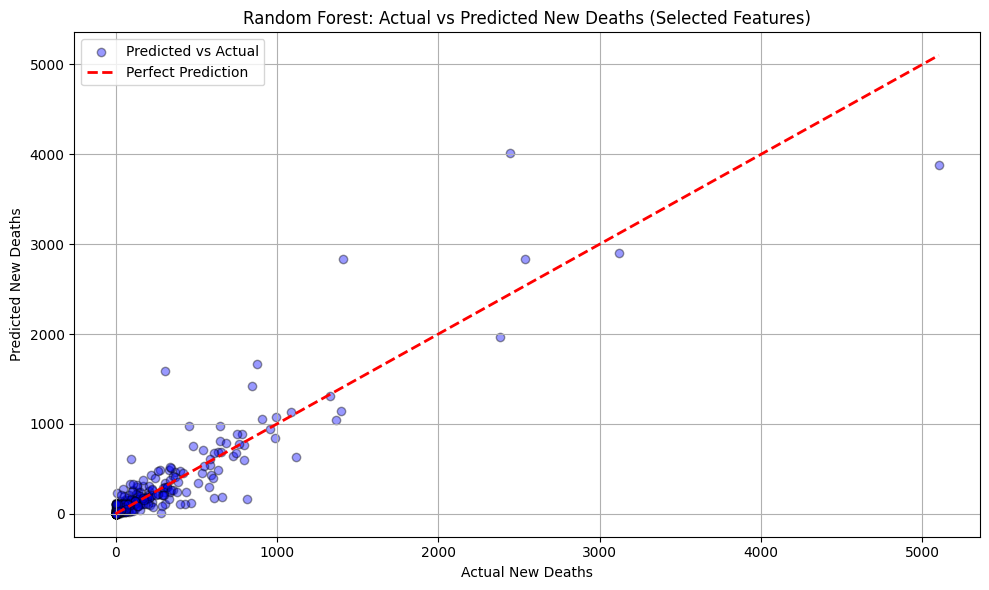

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_excel('/content/weekly_covid_data_combined.xlsx')

# Filter out rows with missing population
df = df[df['population'] > 0]

# Create target variable: new death rate
df['new_death_rate'] = df['new_deaths'] / df['population']
df = df[df['new_death_rate'].notna()]  # Drop rows with missing target

# Define the selected features
selected_features = [
    'stringency_index', 'new_tests', 'population', 'population_density',
    'new_vaccinations', 'aged_70_older', 'diabetes_prevalence',
    'median_age', 'aged_65_older', 'cardiovasc_death_rate'
]

# Ensure all selected features exist in the DataFrame
selected_features = [f for f in selected_features if f in df.columns]

# Create new DataFrame with only selected features
X = df[selected_features].copy().fillna(0)
y = df['new_death_rate']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the model
model = RandomForestRegressor(
    n_estimators=200, max_depth=12, random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Reconstruct actual and predicted deaths
population_test = X_test['population'].values
true_new_deaths = df.loc[X_test.index, 'new_deaths'].values
predicted_new_deaths = y_pred * population_test

# Evaluation
mse = mean_squared_error(true_new_deaths, predicted_new_deaths)
rmse = np.sqrt(mse)
r2 = r2_score(true_new_deaths, predicted_new_deaths)

print("\n--- Evaluation for Random Forest Predicted New Deaths (absolute values) ---")
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(true_new_deaths, predicted_new_deaths, alpha=0.4, color='blue', edgecolor='k', label='Predicted vs Actual')
plt.plot([true_new_deaths.min(), true_new_deaths.max()],
         [true_new_deaths.min(), true_new_deaths.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual New Deaths')
plt.ylabel('Predicted New Deaths')
plt.title('Random Forest: Actual vs Predicted New Deaths (Selected Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Results of our Model while using the features selected by Neural Network



--- Evaluation for Random Forest Predicted New Deaths (absolute values) ---
Mean Squared Error: 19075.649266142544
Root Mean Squared Error: 138.11462365058432
R² Score: 0.9095477804243788


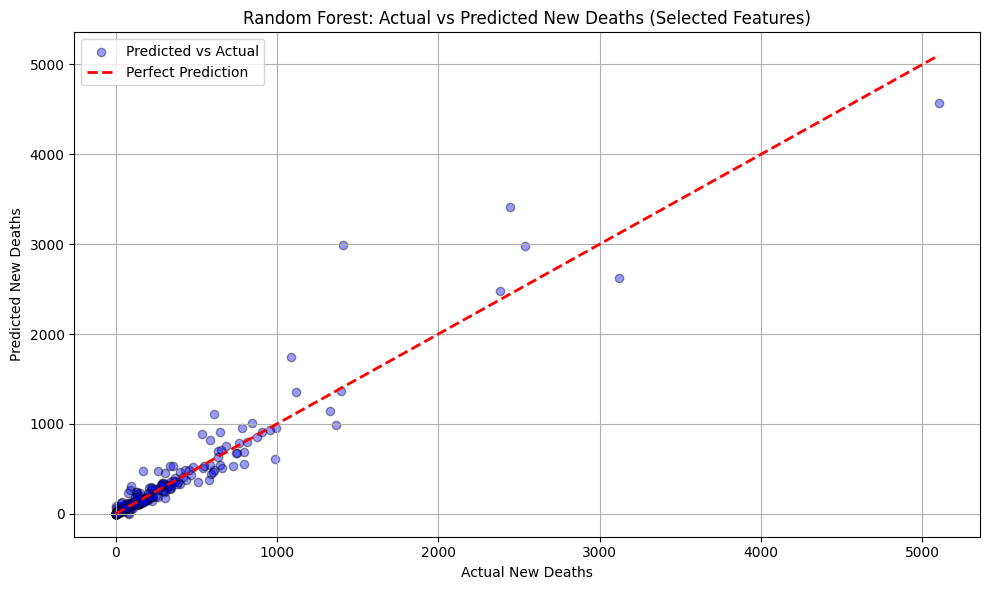

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_excel('/content/weekly_covid_data_combined.xlsx')

# Filter out rows with missing population
df = df[df['population'] > 0]

# Create target variable: new death rate
df['new_death_rate'] = df['new_deaths'] / df['population']
df = df[df['new_death_rate'].notna()]  # Drop rows with missing target

# Define the selected features
selected_features = [
    'hosp_patients', 'icu_patients', 'new_vaccinations', 'female_smokers', 'male_smokers',
    'hospital_beds_per_thousand', 'total_boosters', 'gdp_per_capita', 'stringency_index',
    'people_fully_vaccinated', 'human_development_index', 'cardiovasc_death_rate', 'new_cases',
    'extreme_poverty', 'life_expectancy', 'population_density', 'aged_65_older', 'new_tests',
    'aged_70_older', 'median_age', 'diabetes_prevalence', 'population'
]

# Make sure the selected features exist in the DataFrame
selected_features = [f for f in selected_features if f in df.columns]

# Create the input features DataFrame (X) and fill missing values
X = df[selected_features].copy().fillna(0)
y = df['new_death_rate']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train the Random Forest model
model = RandomForestRegressor(
    n_estimators=200, max_depth=12, random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Reconstruct actual and predicted deaths
population_test = X_test['population'].values
true_new_deaths = df.loc[X_test.index, 'new_deaths'].values
predicted_new_deaths = y_pred * population_test

# Evaluation
mse = mean_squared_error(true_new_deaths, predicted_new_deaths)
rmse = np.sqrt(mse)
r2 = r2_score(true_new_deaths, predicted_new_deaths)

print("\n--- Evaluation for Random Forest Predicted New Deaths (absolute values) ---")
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

# Plot: Actual vs Predicted New Deaths
plt.figure(figsize=(10, 6))
plt.scatter(true_new_deaths, predicted_new_deaths, alpha=0.4, color='blue', edgecolor='k', label='Predicted vs Actual')
plt.plot([true_new_deaths.min(), true_new_deaths.max()],
         [true_new_deaths.min(), true_new_deaths.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual New Deaths')
plt.ylabel('Predicted New Deaths')
plt.title('Random Forest: Actual vs Predicted New Deaths (Selected Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Predicting New Deaths using features selected by LASSO



--- Evaluation for Random Forest Predicted New Deaths (absolute values) ---
Mean Squared Error: 21707.875659365625
Root Mean Squared Error: 147.3359279312606
R² Score: 0.8970663850930467


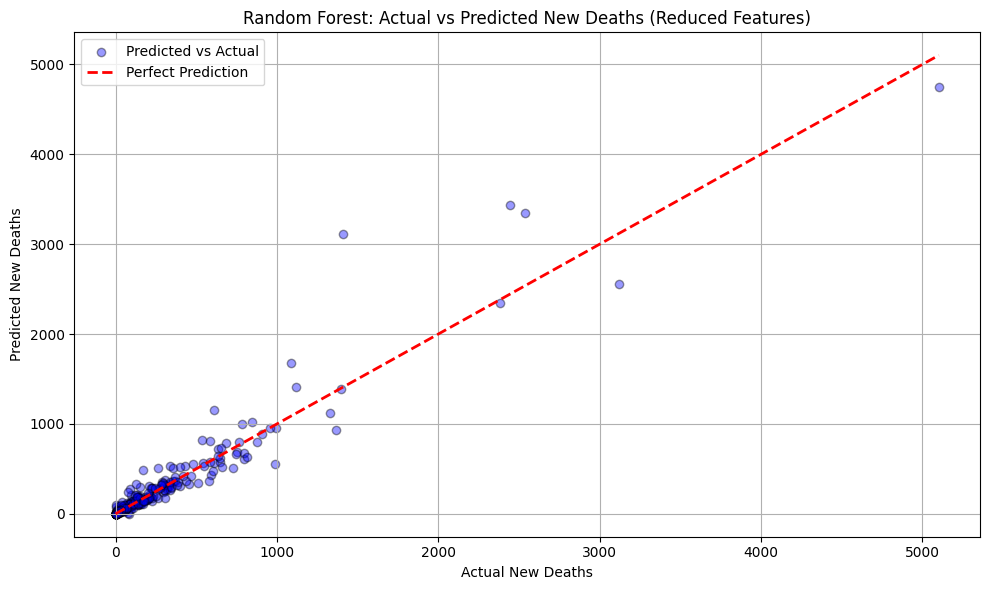

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
df = pd.read_excel('/content/weekly_covid_data_combined.xlsx')

# Filter out rows with missing population
df = df[df['population'] > 0]

# Create target variable: new death rate
df['new_death_rate'] = df['new_deaths'] / df['population']
df = df[df['new_death_rate'].notna()]  # Drop rows with missing target

# Define the selected features
selected_features = [
    'icu_patients', 'hosp_patients', 'hospital_beds_per_thousand',
    'new_cases', 'stringency_index', 'male_smokers',
    'female_smokers', 'new_vaccinations', 'population'
]

# Make sure all selected features exist
selected_features = [f for f in selected_features if f in df.columns]

# Create the input features (X) and fill missing values
X = df[selected_features].copy().fillna(0)
y = df['new_death_rate']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Random Forest
model = RandomForestRegressor(
    n_estimators=200, max_depth=12, random_state=42, n_jobs=-1
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Reconstruct actual and predicted new deaths
population_test = X_test['population'].values
true_new_deaths = df.loc[X_test.index, 'new_deaths'].values
predicted_new_deaths = y_pred * population_test

# Evaluate
mse = mean_squared_error(true_new_deaths, predicted_new_deaths)
rmse = np.sqrt(mse)
r2 = r2_score(true_new_deaths, predicted_new_deaths)

print("\n--- Evaluation for Random Forest Predicted New Deaths (absolute values) ---")
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(true_new_deaths, predicted_new_deaths, alpha=0.4, color='blue', edgecolor='k', label='Predicted vs Actual')
plt.plot([true_new_deaths.min(), true_new_deaths.max()],
         [true_new_deaths.min(), true_new_deaths.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual New Deaths')
plt.ylabel('Predicted New Deaths')
plt.title('Random Forest: Actual vs Predicted New Deaths (Reduced Features)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Visualising the Classification Model


In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load dataset
df = pd.read_excel('/content/weekly_covid_data_combined.xlsx')

# Create binary classification target
df = df[df['population'] > 0]
df['new_death_rate'] = df['new_deaths'] / df['population']
df = df[df['new_death_rate'].notna()]

# Define classification target: high death rate = 1 if above 75th percentile
threshold = df['new_death_rate'].quantile(0.75)
df['high_death_rate'] = (df['new_death_rate'] > threshold).astype(int)

# Drop unnecessary columns
drop_cols = ['date', 'new_deaths', 'new_death_rate', 'location', 'continent']
categorical_cols = [col for col in ['location', 'continent'] if col in df.columns]

X = df.drop(columns=drop_cols + ['high_death_rate'], errors='ignore')
y = df['high_death_rate']

# Include back location and continent for encoding
numerical_cols = X.select_dtypes(include='number').columns.tolist()
all_features = numerical_cols + categorical_cols
X = df[all_features]

# Preprocessor and model
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.9584569732937686
F1 Score: 0.9146341463414634
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       253
           1       0.94      0.89      0.91        84

    accuracy                           0.96       337
   macro avg       0.95      0.94      0.94       337
weighted avg       0.96      0.96      0.96       337



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


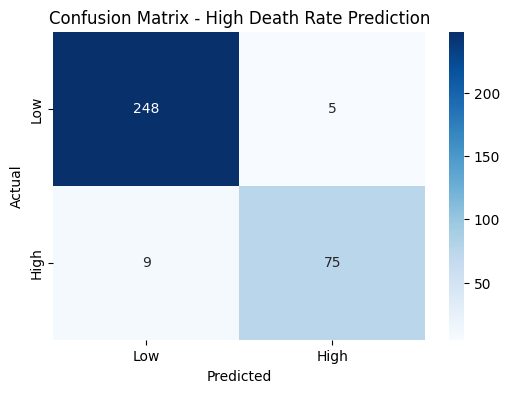

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - High Death Rate Prediction')
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy Score: 0.9465875370919882
F1 Score: 0.896551724137931
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       253
           1       0.87      0.93      0.90        84

    accuracy                           0.95       337
   macro avg       0.92      0.94      0.93       337
weighted avg       0.95      0.95      0.95       337



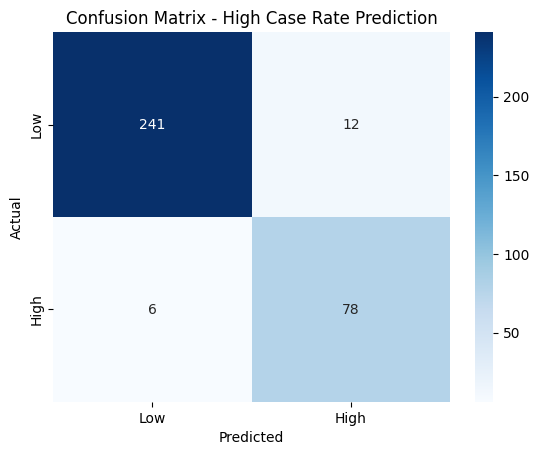

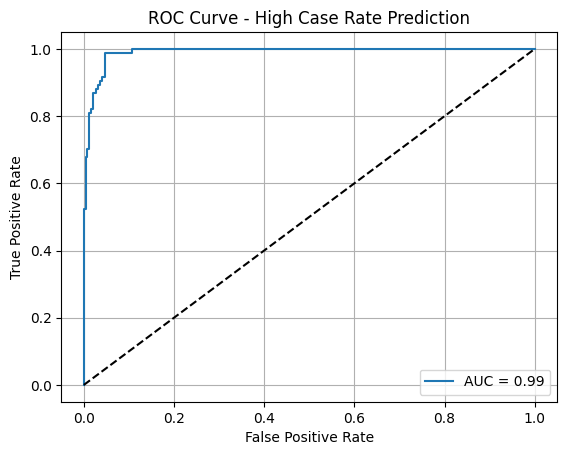

In [ ]:
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Load dataset
df = pd.read_excel('/content/weekly_covid_data_combined.xlsx')

# 2. Create binary target: high_case_rate
df = df[df['population'] > 0]
df['new_case_rate'] = df['new_cases'] / df['population']
df = df[df['new_case_rate'].notna()]

# Define high case rate as above 75th percentile
threshold = df['new_case_rate'].quantile(0.75)
df['high_case_rate'] = (df['new_case_rate'] > threshold).astype(int)

# 3. Define features and target
drop_cols = ['date', 'new_cases', 'new_case_rate', 'high_case_rate']
categorical_cols = [col for col in ['location', 'continent'] if col in df.columns]
numerical_cols = df.drop(columns=drop_cols + categorical_cols, errors='ignore').select_dtypes(include='number').columns.tolist()

X = df[numerical_cols + categorical_cols]
y = df['high_case_rate']

# 4. Preprocessor
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)],
    remainder='passthrough'
)

# 5. Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, random_state=42))
])

# 6. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 7. Train model
model.fit(X_train, y_train)

# 8. Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# 9. Evaluation
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# 10. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - High Case Rate Prediction')
plt.show()

# 11. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - High Case Rate Prediction")
plt.legend()
plt.grid(True)
plt.show()
